In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pcos-picture/PCOSGen-test/images/image10876.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image11269.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image11210.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10743.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10247.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10969.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10633.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10696.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10052.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image11106.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10497.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10349.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10425.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10432.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image11016.jpg
/kaggle/input/pcos-picture/PCOSGen-test/images/image10051.jpg
/kaggle/

In [2]:
# # PCOSGen Kaggle Pipeline — Definitive Publication Version (Aug 2025)
# **Topic:** A Comparative Analysis of ML Models for PCOS Detection: Clinical Data vs. Ultrasound Imagery  
# **Hero Variant:** ConvNeXt‑T + Focal Loss (α=0.25, γ=2.0) + OOF calibration + TTA
# 
# **New Add‑ons (this notebook):**
# 1) Inference latency benchmark (per‑image, per‑batch; with & without TTA)  
# 2) Clean cell‑by‑cell structure for publication  
# 3) Grad‑CAM overlays for PCOS ultrasound images (conv layer auto‑detection)  
# 4) Pre‑ vs Post‑augmentation visualization (train & valid pipelines)  
# 5) Class imbalance plot (+ sampling weights)  
#
# Reproducibility preserved: training unchanged; new visuals/timing run under `eval()` and `no_grad()`.


In [3]:
# ## 1) Environment & Version Locks

!pip -q uninstall -y albumentations albucore
!pip -q install --no-deps albucore==0.0.20 albumentations==1.4.16

import albucore, albumentations
print("albucore:", albucore.__version__, "albumentations:", albumentations.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.6/214.6 kB 8.4 MB/s eta 0:00:00
albucore: 0.0.20 albumentations: 1.4.16


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:

#cell 2
import os, gc, math, time, random, shutil, glob, json, re, hashlib, io, warnings
from dataclasses import dataclass
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc,
    precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from rich import print as rprint

# NEW (for optional SWA)
from torch.optim.swa_utils import AveragedModel, update_bn

warnings.filterwarnings("ignore")

In [5]:
# ## 3) Config (CFG) — Final High-Performance Setup
from dataclasses import dataclass
from pathlib import Path
import os

@dataclass
class CFG:
    # --- Core Settings ---
    seed: int = 42
    num_workers: int = 4
    folds: int = 5

    # --- Model & Training Strategy ---
    backbone: str = "convnext_small.fb_in22k"
    img_size: int = 512
    batch_size: int = 16  # Reduced for larger model/image size
    epochs: int = 18
    lr: float = 1.5e-4
    weight_decay: float = 1e-5
    warmup_epochs: int = 1
    patience: int = 4
    
    # --- System & Performance ---
    use_amp: bool = True
    strict_determinism: bool = False

    # --- Loss Function ---
    use_focal: bool = True
    focal_gamma: float = 2.0
    focal_alpha: float = 0.40
    
    # --- Advanced Techniques ---
    use_hnm: bool = True           # Hard-Negative Mining
    hnm_neg_keep: float = 0.50     # Keep top 50% hardest negatives
    use_mixup: bool = True         # MixUp Regularization
    mixup_prob: float = 0.40
    mixup_alpha: float = 0.20
    ema_decay: float = 0.999

    # --- Test-Time Augmentation (TTA) ---
    tta_scales: tuple = (448, 512, 576)
    tta_weights: tuple = (0.25, 0.50, 0.25) # Give center crop more weight

    # --- Paths ---
    BASE: str = "/kaggle/input/pcos-picture"
    TRAIN_DIR: str = ""
    TEST_DIR: str = ""
    LABELS_FILE: str = ""
    OUT_DIR: str = "/kaggle/working/pcosgen_out"

# --- Path Construction & Directory Creation ---
base_path = Path(CFG.BASE)
train_path = base_path / "PCOSGen-train (1)" / "PCOSGen-train"
test_path = base_path / "PCOSGen-test"
CFG.TRAIN_DIR   = str(train_path / "images")
CFG.TEST_DIR    = str(test_path / "images")
CFG.LABELS_FILE = str(train_path / "class_label.xlsx")
os.makedirs(CFG.OUT_DIR, exist_ok=True)

In [6]:
# ## 4) Determinism & Device Info (robust to fresh sessions)

import os, random, numpy as np, torch
from rich import print as rprint

# ---- Fallbacks if CFG came from an older cell/session ----
if not hasattr(CFG, "strict_determinism"): CFG.strict_determinism = False
if not hasattr(CFG, "use_amp"):            CFG.use_amp = True
if not hasattr(CFG, "num_workers"):        CFG.num_workers = 4

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed(CFG.seed)

device = get_device()
rprint(f"[bold green]Device:[/bold green] {device}")

n_gpus = torch.cuda.device_count()
USE_DP = n_gpus > 1
rprint(f"[bold green]GPUs:[/bold green] {n_gpus}  |  DataParallel: {USE_DP}")

# cuDNN defaults (may be tightened in strict mode)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def _seed_worker(worker_id):
    worker_seed = CFG.seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

_gen = torch.Generator()
_gen.manual_seed(CFG.seed)

# ---------- Strict determinism toggle ----------
if CFG.strict_determinism:
    # Enforce deterministic kernels & math
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Disable TF32 / AMP variability
    if hasattr(torch.backends, "cuda") and hasattr(torch.backends.cuda, "matmul"):
        torch.backends.cuda.matmul.allow_tf32 = False
    if hasattr(torch.backends, "cudnn"):
        torch.backends.cudnn.allow_tf32 = False
    CFG.use_amp = False  # AMP off for bit-for-bit stability

    # Remove nondeterminism from parallelism
    USE_DP = False           # force single-GPU path
    CFG.num_workers = 0      # single-threaded data loading

    rprint("[bold yellow]Strict determinism is ON:[/bold yellow] AMP off, TF32 off, single GPU path, num_workers=0.")
else:
    rprint("[bold cyan]Strict determinism is OFF:[/bold cyan] using AMP/parallelism for speed.")


Device: cuda

GPUs: 2  |  DataParallel: True

Strict determinism is OFF: using AMP/parallelism for speed.

In [7]:
# ## 5) Data Listing & Label Ingestion

def load_labels_from_table(path):
    ext = os.path.splitext(path)[1].lower()
    df_lab = pd.read_excel(path, sheet_name=0) if ext in [".xlsx", ".xls"] else pd.read_csv(path)
    df_lab.columns = [str(c).strip().lower() for c in df_lab.columns]
    img_col = next((c for c in ["imagepath", "image", "filename", "file", "img", "name"] if c in df_lab.columns), None)
    lab_col = next((c for c in ["healthy", "label", "class", "target", "y"] if c in df_lab.columns), None)
    assert img_col is not None and lab_col is not None, "Image or Label column not found in Excel/CSV."
    name = (df_lab[img_col].astype(str).str.strip().apply(os.path.basename).str.lower())
    lab = (
        df_lab[lab_col]
        .astype(str).str.strip().str.lower()
        .map({"1":1, "0":0, "healthy":1, "unhealthy":0, "h":1, "u":0})
        .astype(int)
    )
    table = pd.DataFrame({"image": name, "label": lab}).dropna().drop_duplicates("image", keep="last")
    return dict(zip(table["image"], table["label"]))


def list_images(dir_path):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    return sorted([p for p in glob.glob(str(Path(dir_path) / "*")) if p.lower().endswith(exts)])

train_files, test_files = list_images(CFG.TRAIN_DIR), list_images(CFG.TEST_DIR)
bn_to_path = {os.path.basename(p).lower(): p for p in train_files}
label_map = load_labels_from_table(CFG.LABELS_FILE)

df = pd.DataFrame([(bn_to_path[bn], lab) for bn, lab in label_map.items() if bn in bn_to_path], columns=["path","y"])
rprint(f"[bold]Labeled train images used:[/bold] {len(df)} / {len(train_files)}")
rprint(df.y.value_counts())


Labeled train images used: 3200 / 3200

y
0    2297
1     903
Name: count, dtype: int64

In [8]:
# ## 6) Duplicate & Leakage Scan (MD5 + 8×8 aHash)

def md5_bytes(fp, block=1<<20):
    h = hashlib.md5()
    with open(fp, "rb") as f:
        for chunk in iter(lambda: f.read(block), b""):
            h.update(chunk)
    return h.hexdigest()


def ahash_8x8(fp):
    try:
        img = Image.open(fp).convert("L").resize((8,8), Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32)
        return int((arr > arr.mean()).flatten().dot(1<<np.arange(64)))
    except Exception:
        return None


def scan_duplicates(train_files, test_files):
    out, md5_map, ah_map = [], {}, {}
    for p in train_files:
        md5_map.setdefault(md5_bytes(p), []).append(p)
    for p in test_files:
        md = md5_bytes(p)
        if md in md5_map:
            for t in md5_map[md]:
                out.append(("exact_train_test", os.path.basename(t), os.path.basename(p)))
    # train/train exact dupe
    for md, lst in md5_map.items():
        if len(lst) > 1:
            out.append(("exact_train_train", os.path.basename(lst[0]), os.path.basename(lst[1])))
    # aHash near-dup train/test
    for p in train_files:
        h = ahash_8x8(p)
        if h is not None:
            ah_map.setdefault(h, []).append(p)
    for p in test_files:
        h = ahash_8x8(p)
        if h is not None and h in ah_map:
            for t in ah_map[h]:
                out.append(("ahash_train_test", os.path.basename(t), os.path.basename(p)))
    if out:
        leak_path = f"{CFG.OUT_DIR}/leakage_report.csv"
        pd.DataFrame(out, columns=["type","train_image","test_image"]).to_csv(leak_path, index=False)
        rprint(f"[yellow]Leakage/duplicates report written to {leak_path}[/yellow]")
    else:
        rprint("[green]No exact/near-exact duplicates detected.[/green]")

scan_duplicates(train_files, test_files)


Leakage/duplicates report written to /kaggle/working/pcosgen_out/leakage_report.csv

In [9]:
# ## 7) Transforms (Train & Valid)
IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_tfms = A.Compose([
    A.LongestMaxSize(max_size=CFG.img_size),
    A.PadIfNeeded(CFG.img_size, CFG.img_size, border_mode=cv2.BORDER_REFLECT),
    A.CLAHE(p=0.6),
    A.OneOf([A.GaussNoise(var_limit=(5, 25), p=1), A.ISONoise(p=1)], p=0.5),
    A.RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.85, 1.0), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=10, p=0.5),
    A.OneOf([A.RandomGamma(p=1), A.Sharpen(p=1)], p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

# VALID: remove CLAHE to match inference distribution
valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=CFG.img_size),
    A.PadIfNeeded(CFG.img_size, CFG.img_size, border_mode=cv2.BORDER_REFLECT),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

In [10]:
# ## 9) Model, Loss, Optimizer, Scheduler (+ SAM & MixUp/CutMix)

class PCOSNet(nn.Module):
    def __init__(self, backbone=CFG.backbone, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            backbone, pretrained=pretrained, num_classes=1, in_chans=3, drop_rate=0.2
        )
    def forward(self, x):
        return self.backbone(x).squeeze(1)

# BCE/focal left as-is in your notebook (we're using BCE now)

# Exponential Moving Average of model weights (fixed device handling)
class ModelEMA:
    def __init__(self, model, decay=0.999):
        base = model.module if isinstance(model, nn.DataParallel) else model
        dev = next(base.parameters()).device
        self.ema = PCOSNet(CFG.backbone, pretrained=False).to(dev)
        self.ema.load_state_dict(base.state_dict(), strict=True)
        for p in self.ema.parameters(): p.requires_grad_(False)
        self.decay = decay
    @torch.no_grad()
    def update(self, model):
        msd = (model.module if isinstance(model, nn.DataParallel) else model).state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            esd[k].mul_(self.decay).add_(msd[k], alpha=1.0 - self.decay)

def build_cosine_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(step):
        if step < num_warmup_steps:
            return float(step) / float(max(1, num_warmup_steps))
        progress = float(step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ---------- SAM optimizer (sharpness-aware minimization) ----------
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=True, **kwargs):
        assert rho >= 0.0
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        self.base_optimizer = base_optimizer(params, **kwargs)
        super().__init__(self.base_optimizer.param_groups, defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=True):
        scale = self._grad_norm()
        for group in self.param_groups:
            rho = group["rho"]
            adaptive = group["adaptive"]
            for p in group["params"]:
                if p.grad is None: continue
                e_w = (torch.pow(p, 2) if adaptive else 1.0) * p.grad / (scale + 1e-12)
                p.add_(e_w, alpha=rho)
                self.state[p]["e_w"] = e_w
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=True):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def _grad_norm(self):
        device = self.param_groups[0]["params"][0].device
        total = torch.zeros(1, device=device)
        for group in self.param_groups:
            adaptive = group["adaptive"]
            for p in group["params"]:
                if p.grad is None: continue
                grad = p.grad
                if adaptive: grad = grad * torch.abs(p)
                total.add_(torch.sum(grad.pow(2)))
        return torch.sqrt(total + 1e-12)

    def step(self):  # guard accidental calls
        raise RuntimeError("Call SAM.first_step/second_step instead of step().")

# ---------- MixUp/CutMix (light) ----------
# ---------- MixUp/CutMix (light) ----------

def _rand_beta(alpha, batch_size, device):
    if alpha <= 0:
        return torch.ones(batch_size, device=device)
    return torch.distributions.Beta(alpha, alpha).sample((batch_size,)).to(device)

def _rand_bbox(W, H, lam):
    cut_w = int(W * math.sqrt(1 - lam))
    cut_h = int(H * math.sqrt(1 - lam))
    cx = np.random.randint(0, W)
    cy = np.random.randint(0, H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def apply_mixup_cutmix(x, y, p=1.0):
    """
    x: (B,C,H,W), y: (B,) float in {0,1}
    returns x_mix, y_mix with y_mix shape (B,)
    """
    if not CFG.use_mixup or np.random.rand() > p:
        return x, y

    B, C, H, W = x.shape
    device = x.device

    # 50/50 pick between CutMix and MixUp
    do_cutmix = (np.random.rand() < 0.5) and (CFG.cutmix_alpha > 0)

    if do_cutmix:
        # ---- CutMix ----
        lam = float(_rand_beta(CFG.cutmix_alpha, 1, device).item())  # scalar for the batch
        index = torch.randperm(B, device=device)

        x1, y1, x2, y2 = _rand_bbox(W, H, lam)
        x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

        # effective lambda after box
        lam_eff = 1.0 - ((x2 - x1) * (y2 - y1) / (W * H + 1e-12))

        # labels stay (B,)
        y_mix = lam_eff * y + (1.0 - lam_eff) * y[index]
        return x, y_mix

    else:
        # ---- MixUp ----
        lam_lbl = _rand_beta(CFG.mixup_alpha, B, device)       # (B,)
        index = torch.randperm(B, device=device)

        # For images we need (B,1,1,1) to blend pixels
        lam_img = lam_lbl.view(B, 1, 1, 1)
        x = lam_img * x + (1.0 - lam_img) * x[index]

        # For labels we keep (B,)
        y_mix = lam_lbl * y + (1.0 - lam_lbl) * y[index]
        return x, y_mix



# ## 10) Metrics, Calibration, TTA

def fit_temperature(logits, targets):
    logits = torch.as_tensor(logits, dtype=torch.float32, device=device).unsqueeze(1)
    targets = torch.as_tensor(targets, dtype=torch.float32, device=device).unsqueeze(1)
    model = nn.Linear(1, 1, bias=False).to(device)
    with torch.no_grad():
        model.weight.fill_(1.0)
    opt = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=50)
    def _closure():
        opt.zero_grad()
        loss = F.binary_cross_entropy_with_logits(model(logits), targets)
        loss.backward()
        return loss
    opt.step(_closure)
    return max(1e-3, 1.0 / model.weight.item())


def compute_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    auc_v = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else 0.5
    f1, acc = f1_score(y_true, y_pred), accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    spec, rec = tn / (tn+fp+1e-9), tp / (tp+fn+1e-9)
    return dict(AUC=auc_v, F1=f1, ACC=acc, SPEC_unhealthy=spec, RECALL_healthy=rec, J=rec+spec-1.0)


def best_threshold(y_true, y_prob, metric="J", n=1001):
    thrs = np.linspace(0.0, 1.0, n)
    best_t, best_v = 0.5, -1.0
    for t in thrs:
        v = compute_metrics(y_true, y_prob, thr=t)[metric]
        if v > best_v:
            best_v, best_t = v, t
    return float(best_t), float(best_v)


def find_threshold_for_spec(y_true, y_prob, target_spec=0.80):
    for t in np.linspace(0, 1, 1001):
        if compute_metrics(y_true, y_prob, thr=t)['SPEC_unhealthy'] >= target_spec:
            return float(t)
    return 0.5


def load_ckpt_into_base(ckpt, backbone, device):
    model = PCOSNet(backbone, pretrained=False).to(device)
    sd = ckpt["state_dict"]
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=True)
    return model


def tta_logits(model, xb, do_transpose=True):
    outs = []
    outs.append(model(xb))
    outs.append(model(torch.flip(xb, dims=[-1])))
    outs.append(model(torch.flip(xb, dims=[-2])))
    outs.append(model(torch.flip(torch.flip(xb, [-1]), [-2])))
    if do_transpose:
        xbt = xb.transpose(-1, -2).contiguous()
        outs.append(model(xbt))
        outs.append(model(torch.flip(xbt, dims=[-1])))
        outs.append(model(torch.flip(xbt, dims=[-2])))
        outs.append(model(torch.flip(torch.flip(xbt, [-1]), [-2])))
    return sum(outs) / len(outs)


In [11]:
# === Recovery Cell (place ABOVE "## 11) K-Fold Training") ===
# Defines: IMAGENET constants (if missing), train/valid transforms (if missing),
# USDataset (if missing), _seed_worker/_gen (if missing), and get_loaders (always).

import os, random, numpy as np, pandas as pd, cv2, torch
from torch.utils.data import Dataset, DataLoader
try:
    from torch.utils.data.sampler import WeightedRandomSampler
except Exception:
    from torch.utils.data import WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Imagenet stats (only if missing) ---
if 'IMAGENET_MEAN' not in globals() or 'IMAGENET_STD' not in globals():
    IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# --- Transforms (only if missing) ---
if 'train_tfms' not in globals() or 'valid_tfms' not in globals():
    assert 'CFG' in globals(), "CFG must be defined before this cell."

    train_tfms = A.Compose([
        A.LongestMaxSize(max_size=CFG.img_size),
        A.PadIfNeeded(CFG.img_size, CFG.img_size, border_mode=cv2.BORDER_REFLECT),

        A.CLAHE(p=0.6),

        A.OneOf([
            A.GaussNoise(var_limit=(5, 25), p=1),
            A.ISONoise(p=1),
        ], p=0.5),

        A.RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.85, 1.0), p=0.8),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=10, p=0.5),

        A.OneOf([
            A.RandomGamma(gamma_limit=(80, 120), p=1),
            A.Sharpen(alpha=(0.1, 0.3), lightness=(0.9, 1.1), p=1),
        ], p=0.5),

        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ])

    valid_tfms = A.Compose([
        A.LongestMaxSize(max_size=CFG.img_size),
        A.PadIfNeeded(CFG.img_size, CFG.img_size, border_mode=cv2.BORDER_REFLECT),
        A.CLAHE(p=1.0),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ])

# --- Worker seeding & generator (only if missing) ---
if '_seed_worker' not in globals():
    def _seed_worker(worker_id):
        worker_seed = int(getattr(CFG, "seed", 42)) + int(worker_id)
        np.random.seed(worker_seed)
        random.seed(worker_seed)

if '_gen' not in globals():
    _gen = torch.Generator()
    _gen.manual_seed(int(getattr(CFG, "seed", 42)))

# --- Dataset (only if missing) ---
if 'USDataset' not in globals():
    class USDataset(Dataset):
        def __init__(self, df, transform):
            self.df = df.reset_index(drop=True)
            self.transform = transform
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = cv2.imread(row.path, cv2.IMREAD_UNCHANGED)
            if img is None:
                img = np.zeros((getattr(CFG, "img_size", 448), getattr(CFG, "img_size", 448)), dtype=np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            x = self.transform(image=img)["image"]
            y = int(row.y)
            return x, torch.tensor([y], dtype=torch.float32)

# --- DataLoaders (always define to guarantee presence) ---
def get_loaders(train_df, valid_df):
    class_counts = train_df.y.value_counts()
    weights = (1.0 / train_df.y.map(class_counts)).astype(float).values
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_df), replacement=True)

    dl_train = DataLoader(
        USDataset(train_df, train_tfms),
        batch_size=int(getattr(CFG, "batch_size", 24)),
        sampler=sampler,
        num_workers=int(getattr(CFG, "num_workers", 4)),
        pin_memory=True,
        worker_init_fn=_seed_worker,
        generator=_gen,
    )
    dl_valid = DataLoader(
        USDataset(valid_df, valid_tfms),
        batch_size=int(getattr(CFG, "batch_size", 24)) * 2,
        shuffle=False,
        num_workers=int(getattr(CFG, "num_workers", 4)),
        pin_memory=True,
        worker_init_fn=_seed_worker,
        generator=_gen,
    )
    return dl_train, dl_valid

print("[OK] get_loaders (and dependencies) are defined and ready.")


[OK] get_loaders (and dependencies) are defined and ready.


In [12]:
# ## 11) K-Fold Training (Focal + EMA + Hard-Negative Mining + light MixUp)

from sklearn.model_selection import StratifiedKFold
import math, warnings

# --- Safety defaults if a fresh session is missing new flags ---
USE_HNM       = getattr(CFG, "use_hnm", False)
HNM_NEG_KEEP  = float(getattr(CFG, "hnm_neg_keep", 0.50))
USE_MIXUP     = getattr(CFG, "use_mixup", True)
MIXUP_PROB    = float(getattr(CFG, "mixup_prob", 0.40))
MIXUP_ALPHA   = float(getattr(CFG, "mixup_alpha", 0.20))
EMA_DECAY     = float(getattr(CFG, "ema_decay", 0.999))

skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
df = df.sample(frac=1.0, random_state=CFG.seed).reset_index(drop=True)

oof_logits = np.zeros(len(df), dtype=np.float32)
oof_y = df.y.values.astype(int)
fold_Ts = []

# --- helpers: MixUp & Focal (per-sample) ---
def mixup_batch(x, y, alpha=0.2):
    if alpha <= 0: return x, y
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x = lam * x + (1 - lam) * x[idx]
    y = lam * y + (1 - lam) * y[idx]
    return x, y

def focal_per_sample(logits, targets, alpha=0.4, gamma=2.0):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p_t = torch.exp(-bce)
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    loss = alpha_t * (1 - p_t).pow(gamma) * bce
    return loss

def set_classifier_prior_bias(model, prior):
    base = model.module if isinstance(model, nn.DataParallel) else model
    last_linear = None
    for m in base.modules():
        if isinstance(m, nn.Linear) and m.out_features == 1: last_linear = m
    if last_linear is not None and last_linear.bias is not None:
        with torch.no_grad():
            b = math.log(prior / max(1e-6, 1 - prior))
            last_linear.bias.fill_(b)
        rprint(f"[yellow]Init classifier bias to prior logit={b:.3f} (prior={prior:.3f})[/yellow]")

for fold, (tr_idx, va_idx) in enumerate(skf.split(df, df.y), 1):
    rprint(f"[bold cyan]\n========= FOLD {fold}/{CFG.folds} =========[/bold cyan]")
    tr_df, va_df = df.iloc[tr_idx], df.iloc[va_idx]
    dl_train, dl_valid = get_loaders(tr_df, va_df)

    model = PCOSNet(CFG.backbone).to(device)
    if USE_DP: model = nn.DataParallel(model)

    prior = float((tr_df.y == 1).mean())
    set_classifier_prior_bias(model, prior)

    ema = ModelEMA(model, decay=EMA_DECAY)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = build_cosine_with_warmup(optimizer, len(dl_train)*CFG.warmup_epochs, len(dl_train)*CFG.epochs)
    scaler = torch.amp.GradScaler('cuda', enabled=CFG.use_amp)
    best_auc, best_path, patience = -1.0, f"{CFG.OUT_DIR}/model_fold{fold}.pt", CFG.patience

    for epoch in range(1, CFG.epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in dl_train:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True).squeeze(1)

            if USE_MIXUP and np.random.rand() < MIXUP_PROB:
                xb, yb = mixup_batch(xb, yb, alpha=MIXUP_ALPHA)
                yb = yb.clamp_(0.0, 1.0)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=CFG.use_amp):
                logits = model(xb)
                per_loss = focal_per_sample(logits, yb, alpha=CFG.focal_alpha, gamma=CFG.focal_gamma)

                if USE_HNM:
                    with torch.no_grad():
                        neg_mask = (yb < 0.5)
                        pos_mask = ~neg_mask
                        n_neg = int(neg_mask.sum().item())
                        k = max(1, int(math.ceil(HNM_NEG_KEEP * max(1, n_neg))))
                        
                        if n_neg > 0 and k < n_neg:
                            neg_idx = neg_mask.nonzero(as_tuple=False).squeeze(1)
                            _, topk_idx_local = per_loss[neg_mask].topk(k, largest=True)
                            keep_idx = torch.cat([pos_mask.nonzero(as_tuple=False).squeeze(1), neg_idx[topk_idx_local]], dim=0)
                        else:
                            keep_idx = torch.arange(per_loss.size(0), device=per_loss.device)
                    loss = per_loss[keep_idx].mean()
                else:
                    loss = per_loss.mean()

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_losses.append(loss.detach().float().item())
            ema.update(model)

        rprint(f"Train loss: {np.mean(train_losses):.4f}")

        ema.ema.eval()
        with torch.no_grad():
            val_logits_epoch = np.concatenate([(ema.ema(xb.to(device))).detach().cpu().numpy() for xb, _ in dl_valid])
        probs = 1/(1+np.exp(-val_logits_epoch))
        rprint(f"Val prob stats: min={probs.min():.3f} med={np.median(probs):.3f} max={probs.max():.3f}  >0.5={(probs>=0.5).mean():.3f}")
        m = compute_metrics(va_df.y.values, probs)
        rprint(f"E{epoch:02d}: AUC(EMA)={m['AUC']:.4f} F1={m['F1']:.4f} ACC={m['ACC']:.4f}")

        if m["AUC"] > best_auc:
            best_auc, patience = m["AUC"], CFG.patience
            torch.save({"state_dict": ema.ema.state_dict(), "auc": float(best_auc), "backbone": CFG.backbone}, best_path)
        elif patience < 1:
            rprint("[yellow]Early stopping[/yellow]"); break
        else:
            patience -= 1
            
    # OOF with TTA
    ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
    model_best = load_ckpt_into_base(ckpt, ckpt["backbone"], device)
    model_best.eval()
    with torch.no_grad():
        oof_logits[va_idx] = np.concatenate([tta_logits(model_best, xb.to(device)).detach().cpu().numpy() for xb, _ in dl_valid])
    fold_T = fit_temperature(oof_logits[va_idx], oof_y[va_idx])
    fold_Ts.append(fold_T)
    rprint(f"[bold yellow]Fold {fold} fitted T: {fold_T:.3f}[/bold yellow]")

========= FOLD 1/5 =========

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Init classifier bias to prior logit=-0.934 (prior=0.282)

Train loss: 0.0865

Val prob stats: min=0.311 med=0.377 max=0.448  >0.5=0.000

E01: AUC(EMA)=0.6016 F1=0.0000 ACC=0.7172

Train loss: 0.0817

Val prob stats: min=0.351 med=0.407 max=0.475  >0.5=0.000

E02: AUC(EMA)=0.7662 F1=0.0000 ACC=0.7172

Train loss: 0.0806

Val prob stats: min=0.333 med=0.419 max=0.465  >0.5=0.000

E03: AUC(EMA)=0.7735 F1=0.0000 ACC=0.7172

Train loss: 0.0821

Val prob stats: min=0.363 med=0.426 max=0.459  >0.5=0.000

E04: AUC(EMA)=0.7481 F1=0.0000 ACC=0.7172

Train loss: 0.0816

Val prob stats: min=0.392 med=0.442 max=0.469  >0.5=0.000

E05: AUC(EMA)=0.7901 F1=0.0000 ACC=0.7172

Train loss: 0.0795

Val prob stats: min=0.392 med=0.456 max=0.487  >0.5=0.000

E06: AUC(EMA)=0.8242 F1=0.0000 ACC=0.7172

Train loss: 0.0768

Val prob stats: min=0.373 med=0.462 max=0.503  >0.5=0.009

E07: AUC(EMA)=0.8354 F1=0.0642 ACC=0.7266

Train loss: 0.0765

Val prob stats: min=0.353 med=0.469 max=0.518  >0.5=0.039

E08: AUC(EMA)=0.8464 F1=0.2233 ACC=0.7500

Train loss: 0.0739

Val prob stats: min=0.334 med=0.474 max=0.546  >0.5=0.069

E09: AUC(EMA)=0.8533 F1=0.3556 ACC=0.7734

Train loss: 0.0738

Val prob stats: min=0.314 med=0.476 max=0.589  >0.5=0.098

E10: AUC(EMA)=0.8574 F1=0.4262 ACC=0.7812

Train loss: 0.0722

Val prob stats: min=0.288 med=0.478 max=0.639  >0.5=0.116

E11: AUC(EMA)=0.8566 F1=0.4706 ACC=0.7891

Train loss: 0.0714

Val prob stats: min=0.261 med=0.478 max=0.683  >0.5=0.142

E12: AUC(EMA)=0.8564 F1=0.5074 ACC=0.7906

Train loss: 0.0710

Val prob stats: min=0.241 med=0.478 max=0.714  >0.5=0.155

E13: AUC(EMA)=0.8556 F1=0.5286 ACC=0.7937

Train loss: 0.0690

Val prob stats: min=0.223 med=0.476 max=0.743  >0.5=0.159

E14: AUC(EMA)=0.8555 F1=0.5371 ACC=0.7953

Train loss: 0.0689

Val prob stats: min=0.210 med=0.476 max=0.773  >0.5=0.167

E15: AUC(EMA)=0.8550 F1=0.5625 ACC=0.8031

Early stopping

Fold 1 fitted T: 0.307

========= FOLD 2/5 =========

Init classifier bias to prior logit=-0.934 (prior=0.282)

Train loss: 0.0895

Val prob stats: min=0.291 med=0.348 max=0.394  >0.5=0.000

E01: AUC(EMA)=0.5413 F1=0.0000 ACC=0.7172

Train loss: 0.0791

Val prob stats: min=0.323 med=0.395 max=0.472  >0.5=0.000

E02: AUC(EMA)=0.6891 F1=0.0000 ACC=0.7172

Train loss: 0.0785

Val prob stats: min=0.318 med=0.420 max=0.530  >0.5=0.005

E03: AUC(EMA)=0.7657 F1=0.0326 ACC=0.7219

Train loss: 0.0808

Val prob stats: min=0.332 med=0.437 max=0.516  >0.5=0.005

E04: AUC(EMA)=0.7792 F1=0.0326 ACC=0.7219

Train loss: 0.0753

Val prob stats: min=0.329 med=0.445 max=0.548  >0.5=0.030

E05: AUC(EMA)=0.7831 F1=0.1700 ACC=0.7406

Train loss: 0.0741

Val prob stats: min=0.315 med=0.453 max=0.597  >0.5=0.056

E06: AUC(EMA)=0.7888 F1=0.2949 ACC=0.7609

Train loss: 0.0723

Val prob stats: min=0.299 med=0.452 max=0.647  >0.5=0.080

E07: AUC(EMA)=0.7923 F1=0.3707 ACC=0.7719

Train loss: 0.0718

Val prob stats: min=0.276 med=0.451 max=0.709  >0.5=0.097

E08: AUC(EMA)=0.7956 F1=0.4362 ACC=0.7859

Train loss: 0.0699

Val prob stats: min=0.260 med=0.450 max=0.760  >0.5=0.100

E09: AUC(EMA)=0.7988 F1=0.4408 ACC=0.7859

Train loss: 0.0702

Val prob stats: min=0.246 med=0.452 max=0.802  >0.5=0.111

E10: AUC(EMA)=0.8029 F1=0.4683 ACC=0.7906

Train loss: 0.0671

Val prob stats: min=0.231 med=0.452 max=0.840  >0.5=0.117

E11: AUC(EMA)=0.8059 F1=0.4766 ACC=0.7906

Train loss: 0.0659

Val prob stats: min=0.215 med=0.454 max=0.867  >0.5=0.141

E12: AUC(EMA)=0.8060 F1=0.5166 ACC=0.7953

Train loss: 0.0666

Val prob stats: min=0.199 med=0.455 max=0.881  >0.5=0.170

E13: AUC(EMA)=0.8070 F1=0.5172 ACC=0.7812

Train loss: 0.0642

Val prob stats: min=0.182 med=0.455 max=0.896  >0.5=0.186

E14: AUC(EMA)=0.8074 F1=0.5400 ACC=0.7844

Train loss: 0.0615

Val prob stats: min=0.167 med=0.455 max=0.909  >0.5=0.222

E15: AUC(EMA)=0.8076 F1=0.5449 ACC=0.7703

Train loss: 0.0637

Val prob stats: min=0.154 med=0.456 max=0.916  >0.5=0.245

E16: AUC(EMA)=0.8070 F1=0.5503 ACC=0.7625

Train loss: 0.0614

Val prob stats: min=0.143 med=0.457 max=0.922  >0.5=0.261

E17: AUC(EMA)=0.8057 F1=0.5345 ACC=0.7469

Train loss: 0.0622

Val prob stats: min=0.133 med=0.457 max=0.926  >0.5=0.269

E18: AUC(EMA)=0.8035 F1=0.5439 ACC=0.7484

Fold 2 fitted T: 0.655

========= FOLD 3/5 =========

Init classifier bias to prior logit=-0.934 (prior=0.282)

Train loss: 0.0910

Val prob stats: min=0.252 med=0.339 max=0.386  >0.5=0.000

E01: AUC(EMA)=0.6334 F1=0.0000 ACC=0.7172

Train loss: 0.0830

Val prob stats: min=0.287 med=0.374 max=0.428  >0.5=0.000

E02: AUC(EMA)=0.6991 F1=0.0000 ACC=0.7172

Train loss: 0.0815

Val prob stats: min=0.303 med=0.390 max=0.459  >0.5=0.000

E03: AUC(EMA)=0.7556 F1=0.0000 ACC=0.7172

Train loss: 0.0817

Val prob stats: min=0.300 med=0.406 max=0.475  >0.5=0.000

E04: AUC(EMA)=0.7733 F1=0.0000 ACC=0.7172

Train loss: 0.0770

Val prob stats: min=0.345 med=0.436 max=0.524  >0.5=0.008

E05: AUC(EMA)=0.7852 F1=0.0538 ACC=0.7250

Train loss: 0.0750

Val prob stats: min=0.334 med=0.445 max=0.557  >0.5=0.045

E06: AUC(EMA)=0.7964 F1=0.2762 ACC=0.7625

Train loss: 0.0746

Val prob stats: min=0.318 med=0.450 max=0.592  >0.5=0.058

E07: AUC(EMA)=0.8058 F1=0.3303 ACC=0.7719

Train loss: 0.0736

Val prob stats: min=0.282 med=0.455 max=0.644  >0.5=0.067

E08: AUC(EMA)=0.8176 F1=0.3750 ACC=0.7812

Train loss: 0.0726

Val prob stats: min=0.247 med=0.458 max=0.698  >0.5=0.086

E09: AUC(EMA)=0.8250 F1=0.4407 ACC=0.7937

Train loss: 0.0728

Val prob stats: min=0.221 med=0.459 max=0.736  >0.5=0.105

E10: AUC(EMA)=0.8320 F1=0.4839 ACC=0.8000

Train loss: 0.0670

Val prob stats: min=0.197 med=0.462 max=0.763  >0.5=0.114

E11: AUC(EMA)=0.8345 F1=0.5039 ACC=0.8031

Train loss: 0.0680

Val prob stats: min=0.180 med=0.464 max=0.788  >0.5=0.125

E12: AUC(EMA)=0.8381 F1=0.5134 ACC=0.8016

Train loss: 0.0654

Val prob stats: min=0.164 med=0.466 max=0.809  >0.5=0.136

E13: AUC(EMA)=0.8399 F1=0.5224 ACC=0.8000

Train loss: 0.0653

Val prob stats: min=0.151 med=0.466 max=0.829  >0.5=0.139

E14: AUC(EMA)=0.8405 F1=0.5259 ACC=0.8000

Train loss: 0.0671

Val prob stats: min=0.139 med=0.466 max=0.844  >0.5=0.147

E15: AUC(EMA)=0.8412 F1=0.5236 ACC=0.7953

Train loss: 0.0621

Val prob stats: min=0.129 med=0.465 max=0.853  >0.5=0.164

E16: AUC(EMA)=0.8402 F1=0.5385 ACC=0.7937

Train loss: 0.0620

Val prob stats: min=0.120 med=0.465 max=0.860  >0.5=0.192

E17: AUC(EMA)=0.8378 F1=0.5658 ACC=0.7937

Train loss: 0.0650

Val prob stats: min=0.114 med=0.465 max=0.866  >0.5=0.217

E18: AUC(EMA)=0.8353 F1=0.5688 ACC=0.7844

Fold 3 fitted T: 0.615

========= FOLD 4/5 =========

Init classifier bias to prior logit=-0.932 (prior=0.282)

Train loss: 0.0899

Val prob stats: min=0.275 med=0.341 max=0.396  >0.5=0.000

E01: AUC(EMA)=0.6331 F1=0.0000 ACC=0.7188

Train loss: 0.0798

Val prob stats: min=0.308 med=0.387 max=0.452  >0.5=0.000

E02: AUC(EMA)=0.7035 F1=0.0000 ACC=0.7188

Train loss: 0.0826

Val prob stats: min=0.333 med=0.431 max=0.495  >0.5=0.000

E03: AUC(EMA)=0.7384 F1=0.0000 ACC=0.7188

Train loss: 0.0780

Val prob stats: min=0.320 med=0.451 max=0.557  >0.5=0.041

E04: AUC(EMA)=0.7793 F1=0.2039 ACC=0.7438

Train loss: 0.0776

Val prob stats: min=0.297 med=0.454 max=0.581  >0.5=0.062

E05: AUC(EMA)=0.7926 F1=0.3273 ACC=0.7688

Train loss: 0.0751

Val prob stats: min=0.258 med=0.456 max=0.606  >0.5=0.084

E06: AUC(EMA)=0.8016 F1=0.4274 ACC=0.7906

Train loss: 0.0716

Val prob stats: min=0.237 med=0.459 max=0.634  >0.5=0.092

E07: AUC(EMA)=0.8110 F1=0.4603 ACC=0.7984

Train loss: 0.0719

Val prob stats: min=0.217 med=0.464 max=0.664  >0.5=0.116

E08: AUC(EMA)=0.8222 F1=0.4724 ACC=0.7906

Train loss: 0.0726

Val prob stats: min=0.193 med=0.467 max=0.701  >0.5=0.123

E09: AUC(EMA)=0.8281 F1=0.4788 ACC=0.7891

Train loss: 0.0719

Val prob stats: min=0.175 med=0.467 max=0.739  >0.5=0.127

E10: AUC(EMA)=0.8290 F1=0.4751 ACC=0.7859

Train loss: 0.0694

Val prob stats: min=0.160 med=0.468 max=0.781  >0.5=0.139

E11: AUC(EMA)=0.8280 F1=0.4758 ACC=0.7797

Train loss: 0.0665

Val prob stats: min=0.143 med=0.467 max=0.814  >0.5=0.147

E12: AUC(EMA)=0.8259 F1=0.4745 ACC=0.7750

Train loss: 0.0663

Val prob stats: min=0.123 med=0.466 max=0.843  >0.5=0.152

E13: AUC(EMA)=0.8240 F1=0.4838 ACC=0.7766

Train loss: 0.0642

Val prob stats: min=0.103 med=0.467 max=0.865  >0.5=0.164

E14: AUC(EMA)=0.8217 F1=0.4982 ACC=0.7766

Train loss: 0.0627

Val prob stats: min=0.087 med=0.466 max=0.880  >0.5=0.189

E15: AUC(EMA)=0.8188 F1=0.4983 ACC=0.7641

Early stopping

Fold 4 fitted T: 0.531

========= FOLD 5/5 =========

Init classifier bias to prior logit=-0.932 (prior=0.282)

Train loss: 0.0914

Val prob stats: min=0.251 med=0.321 max=0.378  >0.5=0.000

E01: AUC(EMA)=0.6094 F1=0.0000 ACC=0.7188

Train loss: 0.0798

Val prob stats: min=0.303 med=0.393 max=0.440  >0.5=0.000

E02: AUC(EMA)=0.6898 F1=0.0000 ACC=0.7188

Train loss: 0.0797

Val prob stats: min=0.331 med=0.417 max=0.480  >0.5=0.000

E03: AUC(EMA)=0.7431 F1=0.0000 ACC=0.7188

Train loss: 0.0756

Val prob stats: min=0.338 med=0.435 max=0.560  >0.5=0.031

E04: AUC(EMA)=0.7578 F1=0.1900 ACC=0.7469

Train loss: 0.0765

Val prob stats: min=0.338 med=0.452 max=0.629  >0.5=0.041

E05: AUC(EMA)=0.7667 F1=0.2330 ACC=0.7531

Train loss: 0.0760

Val prob stats: min=0.351 med=0.463 max=0.627  >0.5=0.041

E06: AUC(EMA)=0.7768 F1=0.2233 ACC=0.7500

Train loss: 0.0732

Val prob stats: min=0.345 med=0.470 max=0.645  >0.5=0.062

E07: AUC(EMA)=0.7871 F1=0.2818 ACC=0.7531

Train loss: 0.0740

Val prob stats: min=0.314 med=0.473 max=0.702  >0.5=0.127

E08: AUC(EMA)=0.7956 F1=0.3831 ACC=0.7484

Train loss: 0.0710

Val prob stats: min=0.286 med=0.476 max=0.761  >0.5=0.177

E09: AUC(EMA)=0.7998 F1=0.4710 ACC=0.7578

Train loss: 0.0683

Val prob stats: min=0.260 med=0.473 max=0.814  >0.5=0.189

E10: AUC(EMA)=0.8029 F1=0.4784 ACC=0.7547

Train loss: 0.0699

Val prob stats: min=0.243 med=0.474 max=0.844  >0.5=0.212

E11: AUC(EMA)=0.8034 F1=0.4873 ACC=0.7469

Train loss: 0.0657

Val prob stats: min=0.222 med=0.476 max=0.875  >0.5=0.237

E12: AUC(EMA)=0.8058 F1=0.5241 ACC=0.7531

Train loss: 0.0662

Val prob stats: min=0.208 med=0.478 max=0.895  >0.5=0.252

E13: AUC(EMA)=0.8063 F1=0.5337 ACC=0.7516

Train loss: 0.0645

Val prob stats: min=0.198 med=0.477 max=0.906  >0.5=0.252

E14: AUC(EMA)=0.8065 F1=0.5220 ACC=0.7453

Train loss: 0.0655

Val prob stats: min=0.189 med=0.475 max=0.908  >0.5=0.241

E15: AUC(EMA)=0.8068 F1=0.5150 ACC=0.7469

Train loss: 0.0628

Val prob stats: min=0.183 med=0.475 max=0.911  >0.5=0.241

E16: AUC(EMA)=0.8060 F1=0.5150 ACC=0.7469

Train loss: 0.0631

Val prob stats: min=0.177 med=0.474 max=0.915  >0.5=0.245

E17: AUC(EMA)=0.8049 F1=0.5163 ACC=0.7453

Train loss: 0.0634

Val prob stats: min=0.168 med=0.475 max=0.919  >0.5=0.250

E18: AUC(EMA)=0.8037 F1=0.5235 ACC=0.7469

Fold 5 fitted T: 0.605

In [13]:
# === Cell 11.9R: Final Preflight Guards ===
import os, sys, platform, json
import torch, sklearn, timm, albumentations as A

# 1) Basic env
print("Python:", sys.version)
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available(), "| GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"  - GPU{i}:", torch.cuda.get_device_name(i))
print("scikit-learn:", sklearn.__version__)
print("timm:", timm.__version__)
print("albumentations:", A.__version__)

# 2) CFG sanity (ensure not MockCFG)
assert "CFG" in globals(), "CFG is not defined."
assert type(CFG).__name__ != "MockCFG", "Remove the old MockCFG/dummy OOF cell."
for k in ["BASE","TRAIN_DIR","TEST_DIR","LABELS_FILE","OUT_DIR","img_size","folds","batch_size"]:
    assert hasattr(CFG, k), f"CFG.{k} missing."

# 3) Path sanity
assert os.path.isdir(CFG.TRAIN_DIR), f"TRAIN_DIR not found: {CFG.TRAIN_DIR}"
if not os.path.isdir(CFG.TEST_DIR):
    print(f"[warn] TEST_DIR not found: {CFG.TEST_DIR} (latency/test inference will fallback to train set)")
os.makedirs(CFG.OUT_DIR, exist_ok=True)

# 4) DataFrame & splits present
assert "df" in globals() and len(df)>0 and {"path","y"}.issubset(df.columns), "Training dataframe `df` not ready."

# 5) OOF pre-check (must exist after training, before Cell 12R)
assert "oof_logits" in globals() and "oof_y" in globals(), "Run training to populate oof_logits and oof_y."
assert len(oof_logits)==len(oof_y)==len(df), "Length mismatch between OOF arrays and df; ensure no dummy OOF cell remains."

print("[OK] Preflight checks passed.")


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124 | CUDA available: True | GPUs: 2
  - GPU0: Tesla T4
  - GPU1: Tesla T4
scikit-learn: 1.2.2
timm: 1.0.15
albumentations: 1.4.16
[OK] Preflight checks passed.


OOF analysis complete. Plots + CIs + thresholds saved in /kaggle/working/pcosgen_out

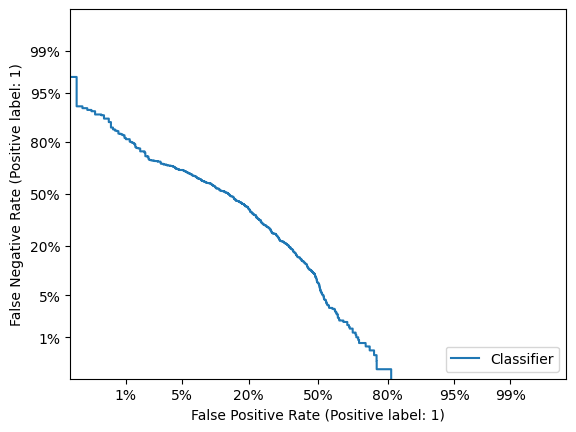

In [14]:
# === Cell 12R (FINAL): OOF Analysis + Calibration + CIs + Core Plots ===
# Final-run knobs (camera-ready)
FAST_MODE = False                                # full bootstrap
N_BOOT = 2000                                    # bootstrap resamples
THR_GRID_STEPS = 20001                           # only used if USE_UNIQUE_THRESHOLDS=False
USE_UNIQUE_THRESHOLDS = True                     # exact thresholds at your score values

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
try:
    from sklearn.metrics import DetCurveDisplay  # available in sklearn >= 1.0
    _HAS_DET = True
except Exception:
    _HAS_DET = False

# --------- Guards: require real training outputs and config ---------
try:
    from rich import print as rprint
except Exception:
    rprint = print

assert 'CFG' in globals(), "CFG not found. Run earlier config cells."
assert 'oof_logits' in globals() and 'oof_y' in globals(), "Run K-Fold training first to populate oof_logits and oof_y."
assert isinstance(oof_logits, np.ndarray) and isinstance(oof_y, np.ndarray), "oof arrays must be numpy."
assert len(oof_logits) == len(oof_y), "oof_logits and oof_y length mismatch."
os.makedirs(CFG.OUT_DIR, exist_ok=True)

# --------- Calibration (temperature scaling) ---------
global_t_temp = fit_temperature(oof_logits, oof_y)   # uses your function from earlier cells
oof_probs     = 1.0 / (1.0 + np.exp(-oof_logits))
oof_probs_cal = 1.0 / (1.0 + np.exp(-(oof_logits / max(1e-3, global_t_temp))))

# --------- Threshold helpers ---------
def best_thr_with_constraints(y_true, y_prob, min_rec=0.85, min_spec=0.85):
    """
    Find threshold maximizing F1 under constraints:
    recall_healthy >= min_rec AND spec_unhealthy >= min_spec.
    Falls back to closest-by-shortfall if no feasible threshold.
    Uses unique-score thresholds if USE_UNIQUE_THRESHOLDS else dense grid.
    """
    y = y_true.astype(int)
    p = y_prob.astype(float)

    if USE_UNIQUE_THRESHOLDS:
        thrs = np.r_[0.0, np.sort(np.unique(p)), 1.0]
    else:
        thrs = np.linspace(0.0, 1.0, THR_GRID_STEPS)

    feasible = []
    best_t, best_m, best_gap = None, None, 1e9
    for t in thrs:
        m = compute_metrics(y, p, thr=float(t))
        gap = max(0.0, min_rec - m["RECALL_healthy"]) + max(0.0, min_spec - m["SPEC_unhealthy"])
        if gap <= 0:
            feasible.append((float(t), m))
        elif (gap < best_gap) or (abs(gap - best_gap) < 1e-12 and (best_m is None or m["F1"] > best_m["F1"])):
            best_t, best_m, best_gap = float(t), m, gap

    if feasible:
        t, m = max(feasible, key=lambda z: z[1]["F1"])
        return float(t), {k: float(v) for k, v in m.items()}, True
    return float(best_t), {k: float(v) for k, v in best_m.items()}, False

# Primary thresholds
thr_j, _   = best_threshold(oof_y, oof_probs_cal, metric="J")           # Youden's J
thr_s80    = find_threshold_for_spec(oof_y, oof_probs_cal, 0.80)        # Spec >= 0.80
thr_85, m_85, feasible_85 = best_thr_with_constraints(oof_y, oof_probs_cal, 0.85, 0.85)

# --------- Bootstrap CIs ---------
def _bootstrap_metric_ci(y, p, fn, n=N_BOOT, alpha=0.95, seed=42, show_progress=False):
    rng = np.random.default_rng(seed)
    vals = []
    N = len(y)
    step = max(50, n // 10)
    for i in range(n):
        idx = rng.integers(0, N, N)
        try:
            vals.append(fn(y[idx], p[idx]))
        except Exception:
            continue
        if show_progress and (i + 1) % step == 0:
            rprint(f"[bootstrap] {i+1}/{n}")
    vals = np.asarray(vals, dtype=float)
    lo = np.nanpercentile(vals, (1 - alpha) / 2 * 100)
    hi = np.nanpercentile(vals, (1 + alpha) / 2 * 100)
    return float(np.nanmean(vals)), float(lo), float(hi)

def _sens_at_spec(y, p, spec_target=0.80):
    t = find_threshold_for_spec(y, p, spec_target)
    m = compute_metrics(y, p, thr=t)
    return m["RECALL_healthy"]

def _brier(y, p):
    y = y.astype(float)
    return float(np.mean((p - y)**2))

auc_roc, ci_roc_lo, ci_roc_hi = _bootstrap_metric_ci(oof_y, oof_probs_cal, roc_auc_score, n=N_BOOT)
ap_mean, ci_ap_lo, ci_ap_hi   = _bootstrap_metric_ci(oof_y, oof_probs_cal, average_precision_score, n=N_BOOT)
brier,  ci_br_lo, ci_br_hi    = _bootstrap_metric_ci(oof_y, oof_probs_cal, _brier, n=N_BOOT)
sens_s80, ci_s_lo, ci_s_hi    = _bootstrap_metric_ci(oof_y, oof_probs_cal, lambda y,p: _sens_at_spec(y,p,0.80), n=N_BOOT)

metrics_ci = {
    "AUC_ROC": {"mean": auc_roc, "ci95": [ci_roc_lo, ci_roc_hi]},
    "AP":      {"mean": ap_mean, "ci95": [ci_ap_lo, ci_ap_hi]},
    "Brier":   {"mean": brier,   "ci95": [ci_br_lo, ci_br_hi]},
    "Sens@Spec80": {"mean": sens_s80, "ci95": [ci_s_lo, ci_s_hi]},
}
with open(f"{CFG.OUT_DIR}/oof_metrics_ci.json", "w") as f:
    json.dump(metrics_ci, f, indent=2)

# --------- Core plots ---------
def save_core_plots(y, p, thr_j, thr_s80):
    # ROC
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("OOF ROC Curve"); plt.legend(); plt.tight_layout()
    plt.savefig(f"{CFG.OUT_DIR}/oof_roc.png", dpi=150); plt.close()

    # PR
    prec, rec, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.figure(); plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("OOF PR Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(f"{CFG.OUT_DIR}/oof_pr.png", dpi=150); plt.close()

    # Reliability (15 bins)
    bins = np.linspace(0,1,16); xs, ys = [], []
    for i in range(15):
        sel = (p>=bins[i]) & (p<bins[i+1])
        if sel.sum() > 0:
            xs.append(float(p[sel].mean())); ys.append(float((y[sel]==1).mean()))
    plt.figure(figsize=(4.2,4.2))
    plt.plot([0,1],[0,1],'--'); plt.scatter(xs, ys)
    plt.xlabel("Confidence"); plt.ylabel("Empirical Positive Rate")
    plt.title("Reliability Diagram")
    plt.tight_layout(); plt.savefig(f"{CFG.OUT_DIR}/oof_reliability.png", dpi=150); plt.close()

    # Confusion matrices
    for thr, name in [(thr_j, "cm_J_star"), (thr_s80, "cm_spec80")]:
        fig = ConfusionMatrixDisplay.from_predictions(
            y, (p >= thr).astype(int), labels=[0,1], display_labels=["Unhealthy","Healthy"], cmap="Blues"
        ).figure_
        plt.title(name); fig.savefig(f"{CFG.OUT_DIR}/{name}.png", dpi=150); plt.close(fig)

    # DET curve
    if _HAS_DET:
        fig = DetCurveDisplay.from_predictions(y, p).plot().figure_
        plt.title("OOF DET Curve")
        fig.savefig(f"{CFG.OUT_DIR}/oof_det.png", dpi=150); plt.close(fig)
    else:
        fpr, tpr, _ = roc_curve(y, p)
        fnr = 1 - tpr
        plt.figure(); plt.plot(fpr, fnr)
        plt.xlabel("FPR"); plt.ylabel("FNR"); plt.title("OOF DET Curve (fallback)")
        plt.tight_layout(); plt.savefig(f"{CFG.OUT_DIR}/oof_det.png", dpi=150); plt.close()

    # Score distribution (per class)
    plt.figure(figsize=(6,4))
    plt.hist(p[y==0], bins=30, alpha=0.65, density=True, label="Unhealthy (0)")
    plt.hist(p[y==1], bins=30, alpha=0.65, density=True, label="Healthy (1)")
    plt.axvline(thr_j,   ls='--', label=f"J*={thr_j:.3f}")
    plt.axvline(thr_s80, ls='-.', label=f"Spec80={thr_s80:.3f}")
    plt.xlabel("Calibrated probability of Healthy (1)"); plt.ylabel("Density")
    plt.title("OOF Score Distribution by Class"); plt.legend()
    plt.tight_layout(); plt.savefig(f"{CFG.OUT_DIR}/oof_score_hist.png", dpi=150); plt.close()

save_core_plots(oof_y, oof_probs_cal, thr_j, thr_s80)

# --------- Save thresholds (JSON) ---------
meta = {
    "global_t_temp": float(global_t_temp),
    "thr_j": float(thr_j),
    "thr_s80": float(thr_s80),
    "thr_85": float(thr_85),
    "m_85": {k: float(v) for k, v in m_85.items()},
    "feasible_85": bool(feasible_85),
    "fast_mode": bool(FAST_MODE),
    "n_boot": int(N_BOOT),
    "thr_grid_steps": int(THR_GRID_STEPS),
    "use_unique_thresholds": bool(USE_UNIQUE_THRESHOLDS),
}
with open(f"{CFG.OUT_DIR}/thresholds.json", "w") as f:
    json.dump(meta, f, indent=2)

rprint(f"[green]OOF analysis complete. Plots + CIs + thresholds saved in {CFG.OUT_DIR}[/green]")


In [15]:
# === Cell 22R: Decision Curve Analysis (DCA) ===
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Guards
assert 'oof_y' in globals() and 'oof_probs_cal' in globals(), "Run Cell 12R first to produce oof_y and oof_probs_cal."
os.makedirs(CFG.OUT_DIR, exist_ok=True)

def decision_curve(y_true: np.ndarray, probs: np.ndarray, thresholds=None):
    """
    Compute decision curve (net benefit) across thresholds for a single model.
    NB_model(t) = TP/N - FP/N * (t / (1 - t))
    NB_treat_all(t) = prevalence - (1 - prevalence) * (t / (1 - t))
    NB_treat_none(t) = 0
    """
    y = y_true.astype(int)
    p = probs.astype(float)
    assert y.shape[0] == p.shape[0] and y.ndim == 1

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)  # avoid 0 and 1 to prevent division issues
    N = len(y)
    prev = y.mean()

    nb_model = []
    nb_all   = []
    nb_none  = np.zeros_like(thresholds)

    # Vectorized-enough loop (99 thresholds)
    y_pos = (y == 1)
    y_neg = ~y_pos
    for t in thresholds:
        pred_pos = (p >= t)
        tp = np.sum(pred_pos & y_pos) / N
        fp = np.sum(pred_pos & y_neg) / N
        odds = t / (1.0 - t)
        nb_model.append(tp - fp * odds)
        nb_all.append(prev - (1.0 - prev) * odds)

    out = pd.DataFrame({
        "threshold": thresholds,
        "nb_model": np.array(nb_model, dtype=float),
        "nb_all":   np.array(nb_all, dtype=float),
        "nb_none":  nb_none.astype(float)
    })
    return out

def bootstrap_nb_ci(y_true, probs, thresholds, n_boot=300, seed=42):
    """
    Bootstrap 95% CI for net benefit at each threshold.
    Keeps it moderate (n_boot=300) to be Kaggle-friendly.
    Returns: (lo, hi) arrays for model NB.
    """
    rng = np.random.default_rng(seed)
    N = len(y_true)
    nb_boot = np.zeros((n_boot, len(thresholds)), dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, N, N)
        d = decision_curve(y_true[idx], probs[idx], thresholds)
        nb_boot[b, :] = d["nb_model"].values
    lo = np.percentile(nb_boot, 2.5, axis=0)
    hi = np.percentile(nb_boot, 97.5, axis=0)
    return lo, hi

# --- Image model (current project) ---
img_dca = decision_curve(oof_y, oof_probs_cal)
thr = img_dca["threshold"].values

# Optional: add bootstrap CI band for image model
img_lo, img_hi = bootstrap_nb_ci(oof_y, oof_probs_cal, thr, n_boot=300, seed=42)
img_dca["nb_img_lo95"] = img_lo
img_dca["nb_img_hi95"] = img_hi

# --- Optional: Clinical model curve if a compatible file exists ---
# We’ll auto-detect a clinical .npz at a common path; if present and y_true matches oof_y, we’ll plot it.
clinical_added = False
possible_paths = [
    "/content/drive/MyDrive/clinical_predictions.npz",
    "/kaggle/input/clinical_predictions/clinical_predictions.npz"
]
for cpath in possible_paths:
    if os.path.exists(cpath):
        try:
            cl = np.load(cpath)
            y_c = cl["y_true"].astype(int)
            p_c = cl["y_proba"].astype(float)
            if y_c.shape == oof_y.shape and np.array_equal(y_c, oof_y):
                clin_dca = decision_curve(y_c, p_c, thresholds=thr)
                # Optional CI for clinical as well (light to save time)
                clin_lo, clin_hi = bootstrap_nb_ci(y_c, p_c, thr, n_boot=300, seed=123)
                clin_dca["nb_clin_lo95"] = clin_lo
                clin_dca["nb_clin_hi95"] = clin_hi
                clinical_added = True
                break
            else:
                print(f"[DCA] Found {cpath}, but y_true does not match current OOF labels. Skipping clinical overlay.")
        except Exception as e:
            print(f"[DCA] Failed to read clinical predictions from {cpath}: {e}")

# --- Save CSV/JSON ---
dca_out = img_dca.copy()
dca_out.rename(columns={"nb_model": "nb_image"}, inplace=True)
if clinical_added:
    dca_out["nb_clinical"]     = clin_dca["nb_model"].values
    dca_out["nb_clin_lo95"]    = clin_dca["nb_clin_lo95"].values
    dca_out["nb_clin_hi95"]    = clin_dca["nb_clin_hi95"].values
dca_out.to_csv(f"{CFG.OUT_DIR}/decision_curve.csv", index=False)

with open(f"{CFG.OUT_DIR}/decision_curve.json", "w") as f:
    json.dump({
        "threshold": dca_out["threshold"].tolist(),
        "nb_none":   dca_out["nb_none"].tolist(),
        "nb_all":    dca_out["nb_all"].tolist(),
        "nb_image":  dca_out["nb_image"].tolist(),
        "nb_img_lo95": dca_out.get("nb_img_lo95", pd.Series([np.nan]*len(thr))).fillna(np.nan).tolist(),
        "nb_img_hi95": dca_out.get("nb_img_hi95", pd.Series([np.nan]*len(thr))).fillna(np.nan).tolist(),
        "nb_clinical": dca_out.get("nb_clinical", pd.Series([np.nan]*len(thr))).fillna(np.nan).tolist(),
        "nb_clin_lo95": dca_out.get("nb_clin_lo95", pd.Series([np.nan]*len(thr))).fillna(np.nan).tolist(),
        "nb_clin_hi95": dca_out.get("nb_clin_hi95", pd.Series([np.nan]*len(thr))).fillna(np.nan).tolist(),
        "clinical_added": bool(clinical_added)
    }, f, indent=2)

# --- Plot ---
plt.figure(figsize=(7,5))
plt.plot(thr, dca_out["nb_none"],  label="Treat None", linestyle="--")
plt.plot(thr, dca_out["nb_all"],   label="Treat All",  linestyle="--")
plt.plot(thr, dca_out["nb_image"], label="Image Model")

# CI band for image model
plt.fill_between(thr, dca_out["nb_img_lo95"], dca_out["nb_img_hi95"], alpha=0.15, label="Image 95% CI")

if clinical_added:
    plt.plot(thr, dca_out["nb_clinical"], label="Clinical Model")
    plt.fill_between(thr, dca_out["nb_clin_lo95"], dca_out["nb_clin_hi95"], alpha=0.15, label="Clinical 95% CI")

plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Threshold probability (risk of PCOS = 'Healthy' class prob)")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis")
plt.legend()
plt.tight_layout()
plt.savefig(f"{CFG.OUT_DIR}/decision_curve.png", dpi=150)
plt.close()

print(f"[DCA] Saved decision curve plot and data -> {CFG.OUT_DIR}")


[DCA] Saved decision curve plot and data -> /kaggle/working/pcosgen_out


In [16]:
# ## 13) Augmentation Preview (Original vs Train/Valid Pipelines)

def _denorm(img_t):
    # img_t: torch tensor CxHxW normalized
    mean = torch.tensor(IMAGENET_MEAN, device=img_t.device)[:, None, None]
    std = torch.tensor(IMAGENET_STD, device=img_t.device)[:, None, None]
    x = img_t * std + mean
    x = (x.clamp(0,1) * 255).byte().permute(1,2,0).cpu().numpy()
    return x


def preview_augmentations(sample_paths, out_path, n_aug=4):
    rows = len(sample_paths)
    cols = 2 + n_aug  # Original + n_aug (train) + 1 (valid)
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    if rows == 1:
        axes = np.expand_dims(axes, 0)

    for r, p in enumerate(sample_paths):
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Original
        axes[r,0].imshow(img); axes[r,0].set_title("Original"); axes[r,0].axis('off')
        # Train aug variants
        for i in range(n_aug):
            xi = train_tfms(image=img)["image"]
            axes[r,1+i].imshow(_denorm(xi)); axes[r,1+i].set_title(f"Train aug {i+1}"); axes[r,1+i].axis('off')
        # Valid pipeline
        xv = valid_tfms(image=img)["image"]
        axes[r,1+n_aug].imshow(_denorm(xv)); axes[r,1+n_aug].set_title("Valid pipeline"); axes[r,1+n_aug].axis('off')

    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()
    rprint(f"[green]Saved augmentation preview -> {out_path}[/green]")

sample_for_preview = [p for p,_ in zip(df.path.values, range(min(4, len(df))))]
preview_augmentations(sample_for_preview, f"{CFG.OUT_DIR}/aug_preview_grid.png", n_aug=4)


Saved augmentation preview -> /kaggle/working/pcosgen_out/aug_preview_grid.png

In [17]:
# ## 14) Class Imbalance Plot (+ Weights)

def plot_class_balance(df, out_path):
    vc = df.y.value_counts().sort_index()
    labels = ["Unhealthy (0)", "Healthy (1)"]
    counts = [vc.get(0,0), vc.get(1,0)]
    total = sum(counts) if sum(counts)>0 else 1
    pct = [c/total*100 for c in counts]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, counts)
    for b, p in zip(bars, pct):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height())}\n({p:.1f}%)", ha='center', va='bottom')
    plt.title("Class Balance (Train Labels)"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()

    # Save stats JSON
    stats = {
        # FIX: Explicitly cast NumPy int64 to Python int for JSON serialization
        "counts": {"0_unhealthy": int(counts[0]), "1_healthy": int(counts[1])},
        "percent": {"0_unhealthy": pct[0], "1_healthy": pct[1]},
    }
    with open(out_path.replace('.png', '.json'), 'w') as f:
        json.dump(stats, f, indent=2)
    rprint(f"[green]Saved class balance plot -> {out_path}[/green]")

plot_class_balance(df, f"{CFG.OUT_DIR}/class_balance.png")

Saved class balance plot -> /kaggle/working/pcosgen_out/class_balance.png

In [18]:
# ## 15) Grad-CAM (Analyzing Correct Predictions & Mistakes) — robust checkpoint pick

@torch.no_grad()
def _to_uint8_rgb(xb):
    mean = torch.tensor(IMAGENET_MEAN, device=xb.device)[None,:,None,None]
    std  = torch.tensor(IMAGENET_STD,  device=xb.device)[None,:,None,None]
    x = xb * std + mean
    return (x.clamp(0,1)*255).byte().permute(0,2,3,1).cpu().numpy()

def _find_last_conv_module(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d): last = m
    return last

def _pick_gradcam_ckpt():
    # Prefer fold1; otherwise pick the best by stored AUC; otherwise first one.
    import glob, os
    p1 = f"{CFG.OUT_DIR}/model_fold1.pt"
    if os.path.exists(p1): return p1
    ckpts = sorted(glob.glob(f"{CFG.OUT_DIR}/model_fold*.pt"))
    if not ckpts: return None
    
    best_ckpt, best_auc = ckpts[0], -1.0
    for p in ckpts:
        try:
            meta = torch.load(p, map_location='cpu', weights_only=False)
            auc = float(meta.get('auc', -1.0))
            if auc > best_auc:
                best_ckpt, best_auc = p, auc
        except Exception:
            pass # Ignore corrupted files
    rprint(f"[green]Grad-CAM auto-selected checkpoint: {os.path.basename(best_ckpt)} (AUC={best_auc:.4f})[/green]")
    return best_ckpt

def gradcam_single(model, x):
    base = model.module if isinstance(model, nn.DataParallel) else model
    conv = _find_last_conv_module(base.backbone if hasattr(base, 'backbone') else base)
    assert conv is not None, "No Conv2d layer found."

    feats, grads = [], []
    def fwd_hook(_, __, output): feats.append(output)
    def bwd_hook(_, __, grad_out): grads.append(grad_out[0])

    h1 = conv.register_forward_hook(fwd_hook)
    h2 = conv.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True); model.eval(); x = x.requires_grad_(True)
    logits = model(x)
    logits.backward() # Grad-CAM works on the gradient of the output logit

    feat, grad = feats[-1], grads[-1]
    h1.remove(); h2.remove()

    weights = grad.mean(dim=(2,3), keepdim=True)
    cam = F.relu((weights * feat).sum(dim=1, keepdim=True))
    cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False).squeeze()
    return ((cam - cam.min()) / (cam.max() - cam.min() + 1e-8)).detach().cpu().numpy(), logits.detach()

def overlay_heatmap(img_rgb_uint8, cam, alpha=0.45):
    heat = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    return (alpha*heat + (1-alpha)*img_rgb_uint8).clip(0,255).astype(np.uint8)

def run_gradcam_on_validation(df, oof_y, oof_probs, n_examples=8, out_dir=f"{CFG.OUT_DIR}/gradcam"):
    os.makedirs(out_dir, exist_ok=True)
    ckpt_path = _pick_gradcam_ckpt()
    if ckpt_path is None:
        rprint("[red]No fold checkpoints found for Grad-CAM. Train first or restore models.[/red]")
        return

    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model = load_ckpt_into_base(ckpt, ckpt["backbone"], device)
    model.eval()

    is_correct = ((oof_probs > 0.5).astype(int) == oof_y)
    conf = np.abs(oof_probs - 0.5)
    k = max(1, n_examples//2)
    top_correct = np.where(is_correct)[0][np.argsort(-conf[is_correct])][:k]
    top_wrong   = np.where(~is_correct)[0][np.argsort(-conf[~is_correct])][:k]
    chosen_indices = np.unique(np.concatenate([top_correct, top_wrong]))
    
    rprint(f"[magenta]Running Grad-CAM on {len(chosen_indices)} examples (correct & mistakes).[/magenta]")
    for i in chosen_indices:
        row = df.iloc[i]
        img = cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2RGB)
        x = valid_tfms(image=img)["image"].unsqueeze(0).to(device)
        cam, logits = gradcam_single(model, x)
        prob = torch.sigmoid(logits).item()
        status = "CORRECT" if is_correct[i] else "MISTAKE"
        fname = f"gradcam_{status}_idx{i}_true{row.y}_pred{prob:.3f}.png"
        overlay = overlay_heatmap(_to_uint8_rgb(x)[0], cam)
        Image.fromarray(overlay).save(os.path.join(out_dir, fname))

    rprint(f"[green]Saved Grad-CAM overlays -> {out_dir}[/green]")

# Note: This cell should be run after Cell 12, which generates the oof_probs_cal variable.
if 'oof_probs_cal' in locals():
    run_gradcam_on_validation(df, oof_y, oof_probs_cal, n_examples=8)
else:
    rprint("[yellow]Skipping Grad-CAM: `oof_probs_cal` not defined. Run Cell 12 first.[/yellow]")

Running Grad-CAM on 8 examples (correct & mistakes).

Saved Grad-CAM overlays -> /kaggle/working/pcosgen_out/gradcam

In [19]:
# === Cell 16R: Robustness / Stress Tests (eval-only) ===
import glob  # <— add this
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, os, math, warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

os.makedirs(CFG.OUT_DIR, exist_ok=True)

def build_stress_tfms(kind: str, level: float, size: int):
    # Base = your valid pipeline
    ops = [
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REFLECT),
        A.CLAHE(p=1.0),
    ]
    if kind == "gauss_noise":
        ops.append(A.GaussNoise(var_limit=(level, level), p=1.0))
    elif kind == "iso_noise":
        ops.append(A.ISONoise(intensity=(0.0, level), p=1.0))
    elif kind == "blur":
        k = int(level) if int(level)%2==1 else int(level)+1
        ops.append(A.GaussianBlur(blur_limit=(k, k), p=1.0))
    elif kind == "brightness":
        ops.append(A.RandomBrightness(limit=level, p=1.0))
    elif kind == "contrast":
        ops.append(A.RandomContrast(limit=level, p=1.0))
    elif kind == "rotate":
        ops.append(A.Rotate(limit=level, p=1.0))
    elif kind == "crop":
        # simulate random zoom/crop keeping aspect; level is min scale
        ops.append(A.RandomResizedCrop(size, size, scale=(level, 1.0), p=1.0))
    # Normalize last
    ops += [A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()]
    return A.Compose(ops)

@torch.no_grad()
def eval_model_on_loader(model, loader):
    model.eval()
    logits = []
    for xb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        logits.append(tta_logits(model, xb).detach().cpu().numpy())
    logits = np.concatenate(logits)
    probs  = 1.0 / (1.0 + np.exp(-(logits / max(1e-3, global_t_temp))))
    return probs

def build_loader_for_df(df_in, tfms, bs=None, nw=None):
    ds = USDataset(df_in, tfms)
    dl = DataLoader(ds, batch_size=bs or CFG.batch_size*2, shuffle=False,
                    num_workers=nw or CFG.num_workers, pin_memory=True)
    return dl

# Load the single best checkpoint for robustness (same selector used in Grad-CAM)
ckpt_path = None
try:
    ckpt_path = [p for p in sorted(glob.glob(f"{CFG.OUT_DIR}/model_fold*.pt")) if os.path.exists(p)]
    assert len(ckpt_path) > 0
    # choose by best stored AUC
    best_auc, best_p = -1.0, None
    for p in ckpt_path:
        meta = torch.load(p, map_location='cpu', weights_only=False)
        auc_v = float(meta.get("auc", -1.0))
        if auc_v > best_auc: best_auc, best_p = auc_v, p
    ckpt_path = best_p
except Exception as e:
    from rich import print as rprint
    rprint(f"[red]No checkpoints found for robustness test: {e}[/red]")
    ckpt_path = None

if ckpt_path is not None:
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model_rb = load_ckpt_into_base(ckpt, ckpt["backbone"], device)

    # Baseline on valid tfms
    base_dl = build_loader_for_df(df, valid_tfms)
    base_probs = eval_model_on_loader(model_rb, base_dl)
    base_m = compute_metrics(df.y.values, base_probs, thr=best_threshold(df.y.values, base_probs)[0])

    # Define stressors (kind, level list)
    STRESS = [
        ("gauss_noise",  [5, 15, 25]),
        ("blur",         [3, 5, 7]),
        ("brightness",   [0.1, 0.2]),
        ("contrast",     [0.1, 0.2]),
        ("rotate",       [5, 10]),
        ("crop",         [0.95, 0.90]),
        ("iso_noise",    [0.2, 0.4]),
    ]

    rows = []
    for kind, levels in STRESS:
        for lv in levels:
            tfms = build_stress_tfms(kind, lv, CFG.img_size)
            dl   = build_loader_for_df(df, tfms)
            probs= eval_model_on_loader(model_rb, dl)
            m    = compute_metrics(df.y.values, probs, thr=best_threshold(df.y.values, probs)[0])
            rows.append({
                "stressor": kind, "level": float(lv),
                "AUC": float(roc_auc_score(df.y.values, probs)),
                "F1": float(m["F1"]),
                "RECALL_healthy": float(m["RECALL_healthy"]),
                "SPEC_unhealthy": float(m["SPEC_unhealthy"])
            })

    rob_df = pd.DataFrame(rows)
    rob_df.to_csv(f"{CFG.OUT_DIR}/robustness_raw.csv", index=False)

    # Δ relative to baseline (AUC & Sens at Spec80)
    # Compute sens@spec80 for baseline and stressors consistently
    base_thr_s80 = find_threshold_for_spec(df.y.values, base_probs, 0.80)
    base_sens    = compute_metrics(df.y.values, base_probs, thr=base_thr_s80)["RECALL_healthy"]

    deltas = []
    for _, r in rob_df.iterrows():
        # recompute sens@spec80 at each condition
        tfms = build_stress_tfms(r["stressor"], r["level"], CFG.img_size)
        dl   = build_loader_for_df(df, tfms)
        probs= eval_model_on_loader(model_rb, dl)
        thr_s80 = find_threshold_for_spec(df.y.values, probs, 0.80)
        sens    = compute_metrics(df.y.values, probs, thr=thr_s80)["RECALL_healthy"]
        deltas.append({
            "stressor": r["stressor"], "level": r["level"],
            "delta_AUC": r["AUC"] - float(roc_auc_score(df.y.values, base_probs)),
            "delta_Sens@Spec80": sens - base_sens
        })
    delta_df = pd.DataFrame(deltas)
    delta_df.to_csv(f"{CFG.OUT_DIR}/robustness_deltas.csv", index=False)

    # Plot Δ bars (grouped by stressor)
    plt.figure(figsize=(9,5))
    for i, met in enumerate(["delta_AUC", "delta_Sens@Spec80"]):
        plt.subplot(1,2,i+1)
        for kind in delta_df["stressor"].unique():
            sub = delta_df[delta_df["stressor"]==kind].sort_values("level")
            xs  = np.arange(len(sub)) + (list(delta_df["stressor"].unique()).tolist().index(kind))*0.0
            plt.plot(sub["level"], sub[met], marker='o', label=kind)
        plt.axhline(0, ls='--', lw=1)
        plt.xlabel("Level"); plt.ylabel(met); plt.title(f"Robustness: {met}")
        if i==1: plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout(); plt.savefig(f"{CFG.OUT_DIR}/robustness_deltas.png", dpi=150); plt.close()

    from rich import print as rprint
    rprint(f"[green]Robustness eval saved to {CFG.OUT_DIR} (CSV + PNG).[/green]")


AttributeError: module 'albumentations' has no attribute 'RandomBrightness'

In [ ]:
# === Cell 17R: Inference Latency Benchmark (safe) ===
import time, json, numpy as np, pandas as pd, os, glob
from torch.utils.data import DataLoader

@torch.no_grad()
def _time_one_pass(model, xb, use_tta=False):
    if device.type == 'cuda':
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    _ = tta_logits(model, xb) if use_tta else model(xb)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    return time.perf_counter() - t0

def _bench_loader():
    # prefer test_files; if empty, fallback to a sample of train df for speed
    paths = []
    if "test_files" in globals() and len(test_files) > 0:
        paths = test_files
    else:
        print("[bench] TEST_FILES empty. Falling back to train set for timing.")
        paths = df.path.values.tolist()
    if len(paths) > 512:  # keep it quick
        paths = paths[:512]
    tfm = build_valid_tfms_for(getattr(CFG, "img_size", 448)) if "build_valid_tfms_for" in globals() else valid_tfms
    ds = USDataset(pd.DataFrame({"path": paths, "y": 0}), tfm)
    return DataLoader(ds, batch_size=getattr(CFG, "batch_size", 16)*2,
                      shuffle=False, num_workers=getattr(CFG, "num_workers", 4), pin_memory=True)

@torch.no_grad()
def benchmark_latency(dataloader, model_paths, warmup_batches=5, timed_batches=20,
                      report_path_json=f"{CFG.OUT_DIR}/latency_report.json",
                      per_batch_csv=f"{CFG.OUT_DIR}/latency_batches.csv"):
    if len(model_paths)==0:
        print("No checkpoints found for latency.")
        return
    ckpt = torch.load(model_paths[0], map_location=device, weights_only=False)
    model = load_ckpt_into_base(ckpt, ckpt["backbone"], device).eval()

    it = iter(dataloader)
    for _ in range(warmup_batches):
        try: xb,_ = next(it)
        except StopIteration:
            it = iter(dataloader); xb,_ = next(it)
        xb = xb.to(device, non_blocking=True)
        _ = model(xb); _ = tta_logits(model, xb)

    it = iter(dataloader); rec = []; count = 0
    for _ in range(timed_batches):
        try: xb,_ = next(it)
        except StopIteration:
            if count==0:
                print("No images available for benchmarking."); return
            break
        xb = xb.to(device, non_blocking=True)
        t_no  = _time_one_pass(model, xb, use_tta=False)
        t_tta = _time_one_pass(model, xb, use_tta=True)
        bsz   = int(xb.shape[0])
        rec.append({
            'batch_index': count, 'batch_size': bsz,
            'sec_no_tta': t_no, 'sec_tta': t_tta,
            'per_img_ms_no_tta': (t_no/bsz)*1000.0,
            'per_img_ms_tta':    (t_tta/bsz)*1000.0,
        }); count += 1

    if not rec:
        print("No timing records written."); return

    pd.DataFrame(rec).to_csv(per_batch_csv, index=False)
    per_no  = np.array([r['per_img_ms_no_tta'] for r in rec])
    per_tta = np.array([r['per_img_ms_tta']    for r in rec])
    summary = {
        'num_batches': len(rec),
        'batch_size_mean': float(np.mean([r['batch_size'] for r in rec])),
        'per_img_ms_no_tta': {'mean': float(per_no.mean()), 'median': float(np.median(per_no)),
                              'p90': float(np.percentile(per_no, 90)), 'p99': float(np.percentile(per_no, 99))},
        'per_img_ms_tta':    {'mean': float(per_tta.mean()), 'median': float(np.median(per_tta)),
                              'p90': float(np.percentile(per_tta, 90)), 'p99': float(np.percentile(per_tta, 99))},
        'throughput_imgs_per_sec_no_tta': float(1000.0 / per_no.mean()),
        'throughput_imgs_per_sec_tta':    float(1000.0 / per_tta.mean()),
    }
    with open(report_path_json, 'w') as f: json.dump(summary, f, indent=2)
    with open(report_path_json.replace('.json', '.txt'), 'w') as f: f.write(json.dumps(summary, indent=2))
    print(f"Latency report -> {report_path_json}; batches -> {per_batch_csv}")

model_paths = sorted(glob.glob(f"{CFG.OUT_DIR}/model_fold*.pt"))
bench_loader = _bench_loader()
benchmark_latency(bench_loader, model_paths)


In [ ]:
# ## 18) Cleanup
gc.collect(); torch.cuda.empty_cache()
print("Done.")


In [ ]:
# === Cell 19R2: Rebuild Appendix to include Decision Curve ===
import base64, json, os, glob
from datetime import datetime
from rich import print as rprint

def _img_data_uri(p):
    try:
        with open(p, 'rb') as f: return 'data:image/png;base64,' + base64.b64encode(f.read()).decode('ascii')
    except Exception: return None

def build_html_appendix(out_html=f"{CFG.OUT_DIR}/appendix.html"):
    imgs = {
        'ROC Curve':        f"{CFG.OUT_DIR}/oof_roc.png",
        'PR Curve':         f"{CFG.OUT_DIR}/oof_pr.png",
        'Reliability':      f"{CFG.OUT_DIR}/oof_reliability.png",
        'DET Curve':        f"{CFG.OUT_DIR}/oof_det.png",
        'Score Histogram':  f"{CFG.OUT_DIR}/oof_score_hist.png",
        'Decision Curve':   f"{CFG.OUT_DIR}/decision_curve.png",   # NEW
        'Class Balance':    f"{CFG.OUT_DIR}/class_balance.png",
        'Augmentations':    f"{CFG.OUT_DIR}/aug_preview_grid.png",
        'CM @ J*':          f"{CFG.OUT_DIR}/cm_J_star.png",
        'CM @ Spec80':      f"{CFG.OUT_DIR}/cm_spec80.png",
        'Robustness Δ':     f"{CFG.OUT_DIR}/robustness_deltas.png",
    }
    gradcams = sorted(glob.glob(f"{CFG.OUT_DIR}/gradcam/*.png"))[:24]

    # Load metrics + latency if present
    metrics_ci, rep = {}, {}
    try:
        with open(f"{CFG.OUT_DIR}/oof_metrics_ci.json") as f: metrics_ci = json.load(f)
    except Exception: pass
    try:
        with open(f"{CFG.OUT_DIR}/latency_report.json") as f: rep = json.load(f)
    except Exception: pass

    # KPI panel
    kpis = {}
    if 'AUC_ROC' in metrics_ci:
        kpis['OOF AUC (95% CI)'] = f"{metrics_ci['AUC_ROC']['mean']:.4f} [{metrics_ci['AUC_ROC']['ci95'][0]:.4f}, {metrics_ci['AUC_ROC']['ci95'][1]:.4f}]"
    if 'AP' in metrics_ci:
        kpis['AP (95% CI)'] = f"{metrics_ci['AP']['mean']:.4f} [{metrics_ci['AP']['ci95'][0]:.4f}, {metrics_ci['AP']['ci95'][1]:.4f}]"
    if 'Brier' in metrics_ci:
        kpis['Brier (95% CI)'] = f"{metrics_ci['Brier']['mean']:.4f} [{metrics_ci['Brier']['ci95'][0]:.4f}, {metrics_ci['Brier']['ci95'][1]:.4f}]"
    if 'per_img_ms_tta' in rep:
        kpis['Latency (TTA) mean'] = f"{rep['per_img_ms_tta']['mean']:.2f} ms/img"
        kpis['Throughput (TTA)']   = f"{rep['throughput_imgs_per_sec_tta']:.1f} img/s"

    styles = "<style>body{font-family:system-ui,sans-serif;margin:2rem}h1,h2{margin-bottom:0.5rem}.grid{display:grid;grid-template-columns:repeat(auto-fit,minmax(300px,1fr));gap:1rem}.card{border:1px solid #ddd;border-radius:8px;padding:1rem;box-shadow:0 2px 4px #0001}table{border-collapse:collapse;width:100%;margin-top:1rem}th,td{border:1px solid #ddd;padding:8px;text-align:left}th{background-color:#f2f2f2}</style>"
    kpi_html = "".join([f"<div class='card'><b>{k}</b><br>{v}</div>" for k, v in kpis.items()])
    plots_html = "".join([f"<div class='card'><h3>{k}</h3><img src='{_img_data_uri(v)}' style='width:100%'></div>" for k, v in imgs.items() if os.path.exists(v)])
    gradcam_html = "".join([f"<div class='card'><b>{os.path.basename(p)}</b><img src='{_img_data_uri(p)}' style='width:100%'></div>" for p in gradcams])

    html = f"<!DOCTYPE html><html><head>{styles}<title>PCOSGen Appendix</title></head><body>"
    html += f"<h1>PCOSGen Appendix</h1><p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>"
    html += f"<h2>Key Metrics</h2><div class='grid'>{kpi_html}</div>"
    if rep:
        html += ("<h2>Latency</h2>"
                 f"<table><tr><th>Mode</th><th>Mean (ms/img)</th><th>Throughput (img/s)</th></tr>"
                 f"<tr><td>No-TTA</td><td>{rep.get('per_img_ms_no_tta',{}).get('mean','')}</td><td>{rep.get('throughput_imgs_per_sec_no_tta','')}</td></tr>"
                 f"<tr><td>TTA</td><td>{rep.get('per_img_ms_tta',{}).get('mean','')}</td><td>{rep.get('throughput_imgs_per_sec_tta','')}</td></tr></table>")
    html += f"<h2>Core Plots</h2><div class='grid'>{plots_html}</div>"
    html += f"<h2>Grad-CAM Examples</h2><div class='grid'>{gradcam_html}</div>"
    html += "</body></html>"

    with open(out_html, 'w') as f: f.write(html)
    rprint(f"[green]HTML appendix updated with Decision Curve -> {out_html}[/green]")

build_html_appendix()


In [ ]:
# === Cell 21: Model Card JSON ===
import json, os, platform, torch, time

card = {
    "project": "PCOS ultrasound classification (ConvNeXt-T)",
    "created_utc": int(time.time()),
    "data": {
        "train_dir": CFG.TRAIN_DIR,
        "test_dir": CFG.TEST_DIR,
        "labels_file": CFG.LABELS_FILE,
        "num_train_images": int(len(df)),
        "class_balance": df.y.value_counts().to_dict()
    },
    "training": {
        "folds": CFG.folds,
        "img_size": CFG.img_size,
        "epochs": CFG.epochs,
        "lr": CFG.lr,
        "weight_decay": CFG.weight_decay,
        "optimizer": "AdamW",
        "scheduler": "Cosine w/ warmup",
        "use_amp": bool(CFG.use_amp),
        "mixup": {"enabled": bool(getattr(CFG, "use_mixup", True)), "alpha": float(getattr(CFG, "mixup_alpha", 0.2))},
        "focal": {"enabled": bool(getattr(CFG, "use_focal", True)), "alpha": float(CFG.focal_alpha), "gamma": float(CFG.focal_gamma)},
        "ema_decay": float(getattr(CFG, "ema_decay", 0.999))
    },
    "hardware": {
        "cuda_available": torch.cuda.is_available(),
        "num_gpus": torch.cuda.device_count(),
        "gpus": [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())],
        "platform": platform.platform()
    },
    "calibration": {
        "temperature": float(global_t_temp)
    },
    "artifacts": {
        "out_dir": CFG.OUT_DIR,
        "thresholds_json": f"{CFG.OUT_DIR}/thresholds.json",
        "metrics_ci_json": f"{CFG.OUT_DIR}/oof_metrics_ci.json",
        "latency_json": f"{CFG.OUT_DIR}/latency_report.json",
        "appendix_html": f"{CFG.OUT_DIR}/appendix.html"
    },
    "notes": "Patient-level grouping not available; stratified label splits used. Evaluate external site/device if possible."
}

with open(f"{CFG.OUT_DIR}/model_card.json", "w") as f:
    json.dump(card, f, indent=2)
print(f"Model card saved -> {CFG.OUT_DIR}/model_card.json")


In [ ]:
!zip -qr /kaggle/working/pcosgen_artifacts.zip /kaggle/working/pcosgen_out




